# Data choosing and filtering


description for the method:

first position : Madgwick(x,y,z,w)  and Mocap(x,y,z,w) <br>
possible quat transformations method: <br>
Madgwick(x,y,z,w)----(w_flip)---->Madgwick(w,x,y,z)----(quat_turn)----> Mocap(w,y,x,z)----(MAD_to_MOC)---->Mocap(w,x,y,z)----(w_back_flip)---->Mocap(x,y,z,w)

Madgwick(x,y,z,w)----(w_flip)---->Madgwick(w,x,y,z)----(MAD_to_MOC)---->Madgwick(w,y,x,z)----(quat_turn)---->Mocap(w,x,y,z)----(w_back_flip)---->Mocap(x,y,z,w)

#### ================Madgwick algortihm======================<br>
The method we're goin to use:<br>

1st step:<br>
transform_quat:
from tha d_stand dadStream, we are going to use that to do the: (quat_turn)

2nd step:<br>
transforming the madgwick quaternions
Madgwick(x,y,z,w)----(w_flip)---->Madgwick(w,x,y,z)----(MAD_to_MOC)---->Madgwick(w,y,x,z)----(quat_turn)----> Mocap(w,x,y,z)----(w_back_flip)---->Mocapt(x,y,z,w)<br>

we can compare this with the original Mocap quaternions and the quaternions of the transformer network

#### ===============Transformer network========================<br>
for the transformer netwrok:<br>
we want to do a comparison with the Madgwick algorithm, which works like this:<br>
Madgwick(Acc,Gyr,Mag)===>Madgwick(x,y,z,w)===(transformations)===>Mocap(x,y,z,w)<br>

therefore, we want to teach our network the following process:<br>
Transformer(Acc,Gyr,Mag)===>Mocap(x,y,z,w)<br>

at this point we can compare all of our results with graphs<br>
we have to keep in mind, that the tarnsformer network will give values only form the 128th step<br>

#### ==============Euler representation=====================<br>
The functio we are using needs the quaternions in this shape: quat(w,x,y,z)<br>
lets call this function: Euler<br>
so Mocap(w,x,y,z)----(Euler)---->Mocap(a,b,g)=~=MocapE<br>

so we have to transform our quaternions in the shape shown before:<br>
MocapQ(x,y,z,w)----(w_flip)---->MocapQ(w,x,y,z)----(Euler)---->MocapE(a,b,g) <br>
With this method we will have three different representations:
MocapE from the mocap data, MadgwickE from the madgwick algorith and TransformE from the transformer network

in theory we could use MocapE here, but our Euler function doesn't tranform MocapQ into MocapE precisely unfortunately<br>

now we can represent the differences between the mocap and madgwick algortihm and aldo between the mocap and the the transform network <br>
also we can compare the two methods: Madgwick and Transform<br>

This was the Theory, this how we implemented it:<br>

#### Algorithm schematic
<img src="../doc/pics/Algorithm.png">

In [1]:
# Imports
import Transformer
from tensorflow.keras.optimizers import Adam

from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataStreamPreprocessor import DataStream, LastDimensionNormalizer, Batcher
from Quaternion_functions import w_flip, w_back_flip, MOC_to_MAD, MAD_to_MOC, transform, turn, distance_check, mocap_correction
from Quaternion_functions import quaternion_to_euler_angle_vectorized1
import matplotlib.pyplot
import tensorflow as tf
import time
from pyquaternion import Quaternion

tf.random.set_seed(42) 
np.random.seed(42)

import ahrs

In [3]:
folder = str("../logs/20201030_11_53_56/") # Egybefüggő teszt, könnyen darabolható

# load in the full measurement sequence
d = DataStream(folder)

# Slice the second part for Calibration
d_calib = deepcopy(d)
d_calib.keepData(2600, 18500)

# Calibrate the rest of the measurement (Training, Validation and Test set also)
d.calibrateMag(d_calib)

# Add extra features to the collective database here
d.addFeature(['diff_Timestamp'])

# Apply filter for the rest of the measurement (Training, Validation and Test set also)
d.filterData(31, 'bartlett', [1, 2, 3]) # filter Acc
d.filterData(31, 'bartlett', [4, 5, 6]) # filter Gyro
d.filterData(31, 'bartlett', [7, 8, 9]) # filter Mag

# Slice the first part for Initialization (Calculate the Rotation Qoaternion betwwen MoCap and Sensor coordinate system)
d_stand = deepcopy(d)
d_stand.keepData(0,500)

d.calibMadgwick(d_stand, axis='MOC')

# Slice the third part of the measurement for Training dataset
d_train = deepcopy(d)
d_train.keepData(18600, 42100)
d_train.calcMadgwick()
# If further filtering is needed apply here for only on Training data

# Slice the fourth part of the measurement for Validation dataset
d_valid = deepcopy(d)
d_valid.keepData(43000, 51000)
d_valid.calcMadgwick()
# If further filtering is needed apply here for only on Validation data

# Slice the fifth part of the measurement for Test dataset
d_test = deepcopy(d)
d_test.keepData(51500, 61720)
d_test.calcMadgwick() # bele rakja a sima ahrs-sel számolt madgwickot az adatsorba
# If further filtering is needed apply here for only on Test data

In [4]:
d_train.showHeader()

0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatW
14 - MARG_quatX
15 - MARG_quatY
16 - MARG_quatZ
17 - MARG_rotX
18 - MARG_rotY
19 - MARG_rotZ
20 - diff_Timestamp
21 - Madgwick_X
22 - Madgwick_Y
23 - Madgwick_Z
24 - Madgwick_W


In [4]:
# Test
d_train.addFeature(['Madgwick_W']) #25
d_train.addFeature(['Madgwick_X']) #26
d_train.addFeature(['Madgwick_Y']) #27
d_train.addFeature(['Madgwick_Z']) #28

In [5]:
d_train.showHeader()

0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatX
14 - MARG_quatY
15 - MARG_quatZ
16 - MARG_quatW
17 - MARG_rotX
18 - MARG_rotY
19 - MARG_rotZ
20 - diff_Timestamp
21 - Madgwick_W
22 - Madgwick_X
23 - Madgwick_Y
24 - Madgwick_Z
25 - Madgwick_W
26 - Madgwick_X
27 - Madgwick_Y
28 - Madgwick_Z


In [6]:
# Coorrdinate system correction
#mocapToMadgwick() or madgwickToMocap()
d_train.mocapToMadgwick([21,22,23,24])
d_valid.mocapToMadgwick([21,22,23,24])
d_test.mocapToMadgwick([21,22,23,24])

NameError: name 'q10' is not defined

Calib dataset (no filter)


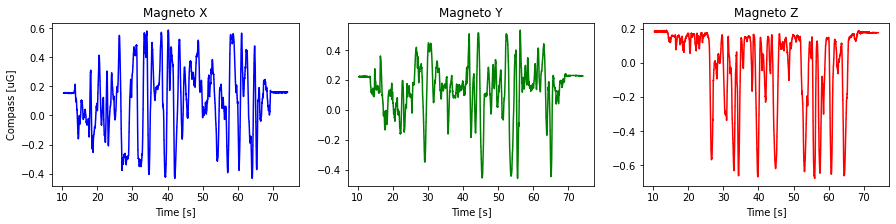

Calibrated and filtered dataset


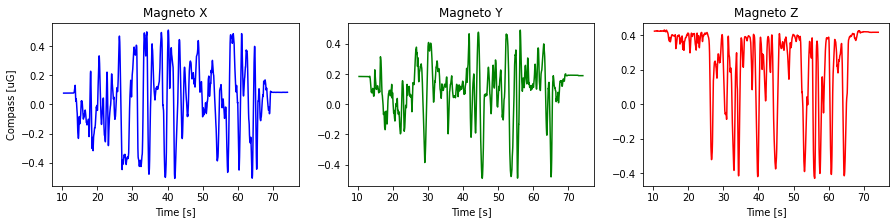

In [4]:
print('Calib dataset (no filter)')
d_calib.plotData(mag=True)
print('Calibrated and filtered dataset')
d.plotData(mag=True, interval=[2600, 18500])

Training data


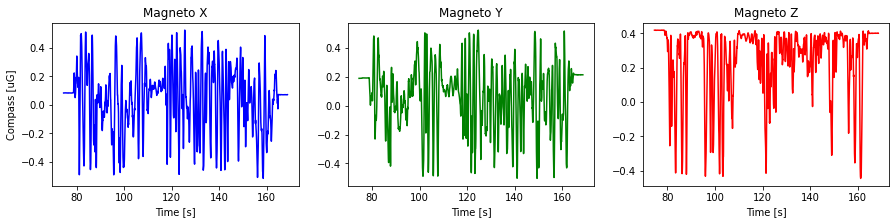

In [5]:
print('Training data')
d_train.plotData(acc=True,gyro=True,mag=True)

In [ ]:
d_test.calibMadgwick(d_stand, plot_distance = True)

## Transformer network parameters

In [91]:
# Actual input and label data for the training. The columns defined in data_const will be constat in each sequence (first value)

#Opcion A: Szekvenciánként az első MoCap quaterniót is megkapja
#data = [20,1,2,3,4,5,6,7,8,9,13,14,15,16] 
#data_const = [-4,-3,-2,-1] 

#Opcion B: Nem kap quaternió bemenetet soha
#data = [20,1,2,3,4,5,6,7,8,9]
#data_const=[]

label = [13,14,15,16] # MoCapet jósoloni (a predikció az init után a saját korábbi becsléseit használja) 

# Define parameters of the Transformer network
num_layers = 10
d_model = 16
dff = 32
num_heads = 16   # d_model / num_heads should be integer
kernel_size = 5
input_size = len(data)
target_size = len(label)
dropout_rate = 0.1

enc_local = 4 #exponenciális dilatáció
enc_repetitions = 2 # (in_seq_len  - enc_local) / enc_repetioin = should be integer  #eponenciális dilatáció száma
dec_local = 2
dec_repetitions = 1 # (tar_seq_len - dec_local) / dec_repetioin = should be integer

in_seq_len = 8
tar_seq_len = 4

batch_size = 256

epochs = 10



## Data preparation for Transformer network

In [92]:
# Parsing the data 
# =============Training data========================
X_alap, X_header, _, _ = d_train.dataParser(data, [], in_seq_len, data_const)
_, _, Y_alap, Y_header = d_train.dataParser([], label, tar_seq_len)
Y_alap = Y_alap[in_seq_len-tar_seq_len:,:,:]

nx = LastDimensionNormalizer()
ny = LastDimensionNormalizer()

X_norm = nx.normalize(X_alap)
Y_norm = ny.normalize(Y_alap)

# Batching the data
batcher = Batcher(batch_size, shuffle=True)
X_train = batcher.batch(X_norm)
Y_train = batcher.batch(Y_norm)

# Dimension check
print('d_train.data: ', d_train.data.shape)
print('X_alap:   ', X_alap.shape, '   Y_alap: ', Y_alap.shape)
print('X_norm:   ', X_norm.shape, '   Y_norm: ', Y_norm.shape)
print('X_train:  ', X_train.shape,' Y_train:', Y_train.shape)

# ==================Test data=====================
X_alap_T, X_header_T,_,_ = d_test.dataParser(data, [], in_seq_len, data_const)
_, _, Y_alap_T, Y_header_T = d_test.dataParser([], label, tar_seq_len)
Y_alap_T = Y_alap_T[in_seq_len-tar_seq_len:,:,:]

#nx = Normalizer()
#ny = Normalizer()

X_norm_T = nx.normalize(X_alap_T)
Y_norm_T = ny.normalize(Y_alap_T)

batcher = Batcher(batch_size, shuffle=True)

X_test = batcher.batch(X_norm_T)
Y_test = batcher.batch(Y_norm_T)

# Dimension check
print('d_test.data: ', d_test.data.shape)
print('X_alap:   ', X_alap_T.shape, '   Y_alap: ', Y_alap_T.shape)
print('X_norm:   ', X_norm_T.shape, '   Y_norm: ', Y_norm_T.shape)
print('X_test:   ', X_test.shape,   ' Y_test: ', Y_test.shape)


d_train.data:  (23500, 21)
X_alap:    (23493, 8, 14)    Y_alap:  (23493, 4, 4)
X_norm:    (23493, 8, 14)    Y_norm:  (23493, 4, 4)
X_train:   (734, 32, 8, 14)  Y_train: (734, 32, 4, 4)
d_test.data:  (10220, 21)
X_alap:    (10213, 8, 14)    Y_alap:  (10213, 4, 4)
X_norm:    (10213, 8, 14)    Y_norm:  (10213, 4, 4)
X_test:    (319, 32, 8, 14)  Y_test:  (319, 32, 4, 4)


## Transformer network setup and train

In [93]:
# Define loss function for the Transformer network
def loss_function(real, pred):
    return tf.reduce_mean(tf.math.square(real-pred))

In [94]:
# Set up the Transformer network
output_size = Y_train.shape[-1]

trans = Transformer.Transformer(num_layers, d_model, kernel_size, num_heads, dff, input_size, target_size, output_size, in_seq_len, tar_seq_len-1, rate=dropout_rate)
trans.setEncoderLogsparseMasks(enc_local,enc_repetitions)
trans.setDecoderLogsparseMasks(dec_local,dec_repetitions)
trans.setLoss(loss_function)
trans.setOptimizer(Adam())

In [95]:
# Epoch number and Training
trans.train(epochs, X_train, Y_train[:,:,:-1,:], Y_train[:,:,-1,:], shuffle=True)

Epoch 1 Batch 0 Loss 0.1874433
Epoch 1 Batch 650 Loss 0.1646669
Epoch 1 Batch 250 Loss 0.1112319
Epoch 1 Batch 500 Loss 0.1082157
Epoch 1 Batch 200 Loss 0.0658052
Epoch 1 Batch 600 Loss 0.0655583
Epoch 1 Batch 350 Loss 0.0651456
Epoch 1 Batch 450 Loss 0.0637826
Epoch 1 Batch 50 Loss 0.0634848
Epoch 1 Batch 100 Loss 0.0552510
Epoch 1 Batch 400 Loss 0.0497432
Epoch 1 Batch 700 Loss 0.0478797
Epoch 1 Batch 550 Loss 0.0470203
Epoch 1 Batch 150 Loss 0.0460185
Epoch 1 Batch 300 Loss 0.0458398
Epoch 1 Loss 0.0445267
Time taken for 1 epoch: 129.8924388885498 secs

Epoch 2 Batch 650 Loss 0.0144058
Epoch 2 Batch 550 Loss 0.0137622
Epoch 2 Batch 100 Loss 0.0137832
Epoch 2 Batch 150 Loss 0.0136541
Epoch 2 Batch 250 Loss 0.0128152
Epoch 2 Batch 450 Loss 0.0125030
Epoch 2 Batch 400 Loss 0.0120617
Epoch 2 Batch 50 Loss 0.0119337
Epoch 2 Batch 700 Loss 0.0118374
Epoch 2 Batch 0 Loss 0.0117939
Epoch 2 Batch 200 Loss 0.0112669
Epoch 2 Batch 500 Loss 0.0106569
Epoch 2 Batch 350 Loss 0.0104872
Epoch 2 Bat

## Madgwick Magic

## Prediction and Results

#### Data operations for successful Madgwick

the transforming quaternion = [-0.15752076 -0.0305034   0.98692205 -0.01004157]


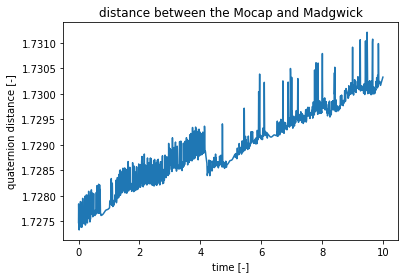

In [41]:
# may take some time
d_test.calibMadgwick(d_stand, plot_distance = True)

In [42]:
d_test.madgwickToMocap(d_stand)

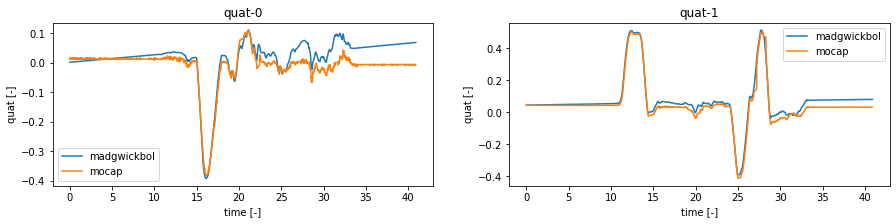

In [43]:
time = np.zeros(len(d_test.madgwick))
for i in range(len(d_test.madgwick)):
    time[i] = 0.004*i
    
distance = distance_check(d_test.data[:,13:17], d_test.madgwick, plot=False, dlist =True)
#plottolás
plt.figure(1, figsize=(15, 3))

plt.subplot(121)
plt.title("quat-0")
plt.plot(time,d_test.madgwick[:,0],label='madgwickbol')
plt.plot(time,d_test.data[:,13],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-1")
plt.plot(time,d_test.madgwick[:,1],label='madgwickbol')
plt.plot(time,d_test.data[:,14],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(2, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-2")
plt.plot(time,d_test.madgwick[:,2],label='madgwickbol')
plt.plot(time,d_test.data[:,15],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-3")
plt.plot(time,d_test.madgwick[:,3],label='madgwickbol')
plt.plot(time,d_test.data[:,16],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(3, figsize=(15, 3))
plt.subplot(111)
plt.title("distance")
plt.plot(time,distance)
plt.xlabel('time [-]')
plt.ylabel('distance [-]')
plt.show()

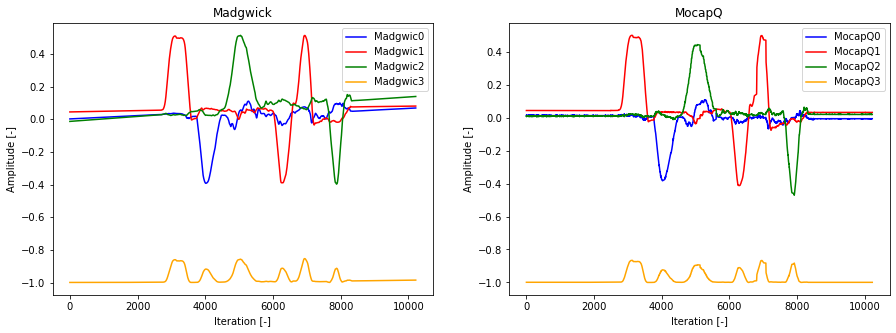

In [44]:
plt.figure(3, figsize=(15, 5))
plt.subplot(121)
plt.title("Madgwick")
plt.plot(d_test.madgwick[:,0], color='blue', label='Madgwic0')
plt.plot(d_test.madgwick[:,1], color='red', label='Madgwic1')
plt.plot(d_test.madgwick[:,2], color='green', label='Madgwic2')
plt.plot(d_test.madgwick[:,3], color='orange', label='Madgwic3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(122)
plt.title("MocapQ")
plt.plot(d_test.data[:,13], color='blue', label='MocapQ0')
plt.plot(d_test.data[:,14], color='red', label='MocapQ1')
plt.plot(d_test.data[:,15], color='green', label='MocapQ2')
plt.plot(d_test.data[:,16], color='orange', label='MocapQ3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()

plt.show()

# Prediction

In [45]:
'''
sid = 0
eid = 10000
# Predict on dependent trainig data
pred_onTrain = trans.predict_structured(X_norm[sid:eid,...],Y_norm[sid:eid,:-1,:])
'''

'\nsid = 0\neid = 10000\n# Predict on dependent trainig data\npred_onTrain = trans.predict_structured(X_norm[sid:eid,...],Y_norm[sid:eid,:-1,:])\n'

In [46]:
'''
# plot on Train
# Plot in normalised space on training data (if it fits it possibly means OverFitting)
for i in range(4):
    plt.figure(i)
    plt.title(str(i)+". Quatcoord")
    plt.plot(Y_norm[sid:eid,-1,i], label='Training_data')     # dependent training data
    plt.plot(pred_onTrain[:,i], label='Prediction')
    plt.legend()

plt.show()
'''

'\n# plot on Train\n# Plot in normalised space on training data (if it fits it possibly means OverFitting)\nfor i in range(4):\n    plt.figure(i)\n    plt.title(str(i)+". Quatcoord")\n    plt.plot(Y_norm[sid:eid,-1,i], label=\'Training_data\')     # dependent training data\n    plt.plot(pred_onTrain[:,i], label=\'Prediction\')\n    plt.legend()\n\nplt.show()\n'

# Dernormalization

In [96]:
sid = 3000
eid = 4500
# Predict on dependent training data
pred_onTest = trans.predict_structured(X_norm_T[sid:eid,...],Y_norm_T[:,:-1,:])

Y_denorm_T = ny.denormalize(Y_norm_T)
denorm_pred_onTest = ny.denormalize(pred_onTest)

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


# Plot

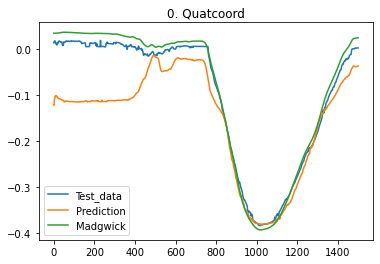

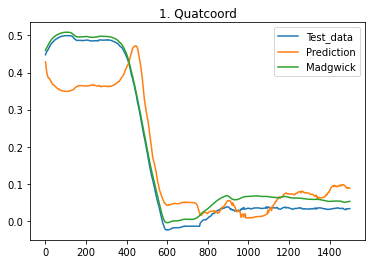

In [97]:
# Plot in normalized space with Madgwick. If it fits it means a good trainig.
for i in range(4):
    plt.figure(i)
    plt.title(str(i)+". Quatcoord")
    plt.plot(Y_denorm_T[sid:eid,-1,i], label='Test_data') # Independent test data
    plt.plot(denorm_pred_onTest[:,i], label='Prediction')
    #plt.plot(d_test.madgwick[sid:eid,i], label='Madgwick')
    plt.legend()
plt.show()

# Euler

In [98]:
TransformQ = denorm_pred_onTest
MadgwickQ = d_test.madgwick[sid:eid,:]
TestQ = Y_denorm_T[sid:eid,-1,:]
#TestQ = d_test.data[sid:eid,13:17]



TransformQ = w_flip(TransformQ)
MadgwickQ = w_flip(MadgwickQ)
TestQ = w_flip(TestQ)

TransformE = np.zeros((eid-sid, 3))
MadgwickE = np.zeros((eid-sid, 3))
TestE = np.zeros((eid-sid, 3))

for i in range(eid-sid):
    TransformE[i,:] = quaternion_to_euler_angle_vectorized1(TransformerQ[i,0], TransformerQ[i,1], TransformerQ[i,2], TransformerQ[i,3])
    MadgwickE[i,:] = quaternion_to_euler_angle_vectorized1(MadgwickQ[i,0], MadgwickQ[i,1], MadgwickQ[i,2], MadgwickQ[i,3])
    TestE[i,:] = quaternion_to_euler_angle_vectorized1(TestQ[i,0], TestQ[i,1], TestQ[i,2], TestQ[i,3])

distance_alfa_M=np.zeros((eid-sid))
distance_beta_M=np.zeros((eid-sid))
distance_gamma_M=np.zeros((eid-sid))

for i in range(eid-sid):
    distance_alfa_M[i]= TestE[i,0] - MadgwickE[i,0]
    if (distance_alfa_M[i] > 180):
        distance_alfa_M[i]-=360
    if (distance_alfa_M[i] < -180):
        distance_alfa_M[i]+=360
    distance_beta_M[i]= TestE[i,1] - MadgwickE[i,1]
    if (distance_beta_M[i] > 180):
        distance_beta_M[i]-=360
    if (distance_beta_M[i] < -180):
        distance_beta_M[i]+=360
    distance_gamma_M[i]= TestE[i,2] - MadgwickE[i,2]
    if (distance_gamma_M[i] > 180):
        distance_gamma_M[i]-=360
    if (distance_gamma_M[i] < -180):
        distance_gamma_M[i]+=360
    
distance_alfa_T=np.zeros((eid-sid))
distance_beta_T=np.zeros((eid-sid))
distance_gamma_T=np.zeros((eid-sid))

for i in range(eid-sid):
    distance_alfa_T[i]= TestE[i,0] - TransformE[i,0]
    if (distance_alfa_T[i] > 180):
        distance_alfa_T[i]-=360
    if (distance_alfa_T[i] < -180):
        distance_alfa_T[i]+=360
    distance_beta_T[i]= TestE[i,1] - TransformE[i,1]
    if (distance_beta_T[i] > 180):
        distance_beta_T[i]-=360
    if (distance_beta_T[i] < -180):
        distance_beta_T[i]+=360
    distance_gamma_T[i]= TestE[i,2] - TransformE[i,2]
    if (distance_gamma_T[i] > 180):
        distance_gamma_T[i]-=360
    if (distance_gamma_T[i] < -180):
        distance_gamma_T[i]+=360
    

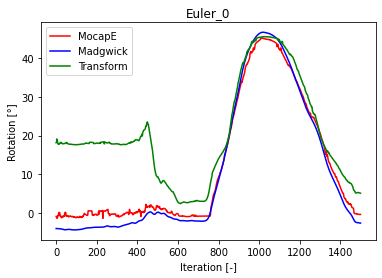

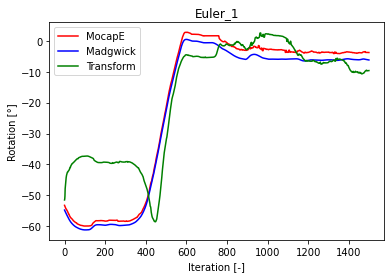

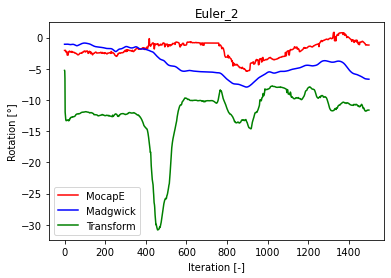

In [99]:
#plots:
plt.title("Euler_0")
plt.plot(TestE[:,0], color='red', label='MocapE')
plt.plot(MadgwickE[:,0], color='blue', label='Madgwick')
plt.plot(TransformE[:,0], color='green', label='Transform')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()

plt.title("Euler_1")
plt.plot(TestE[:,1], color='red', label='MocapE')
plt.plot(MadgwickE[:,1], color='blue', label='Madgwick')
plt.plot(TransformE[:,1], color='green', label='Transform')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()

plt.title("Euler_2")
plt.plot(TestE[:,2], color='red', label='MocapE')
plt.plot(MadgwickE[:,2], color='blue', label='Madgwick')
plt.plot(TransformE[:,2], color='green', label='Transform')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()


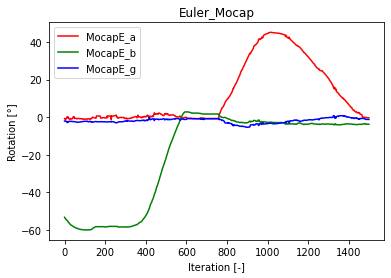

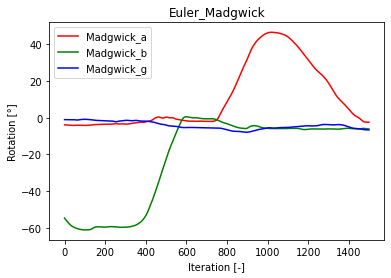

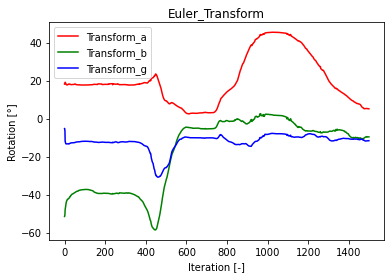

In [100]:
#plots:
plt.title("Euler_Mocap")
plt.plot(TestE[:,0], color='red', label='MocapE_a')
plt.plot(TestE[:,1], color='green', label='MocapE_b')
plt.plot(TestE[:,2], color='blue', label='MocapE_g')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()

plt.title("Euler_Madgwick")
plt.plot(MadgwickE[:,0], color='red', label='Madgwick_a')
plt.plot(MadgwickE[:,1], color='green', label='Madgwick_b')
plt.plot(MadgwickE[:,2], color='blue', label='Madgwick_g')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()

plt.title("Euler_Transform")
plt.plot(TransformE[:,0], color='red', label='Transform_a')
plt.plot(TransformE[:,1], color='green', label='Transform_b')
plt.plot(TransformE[:,2], color='blue', label='Transform_g')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()

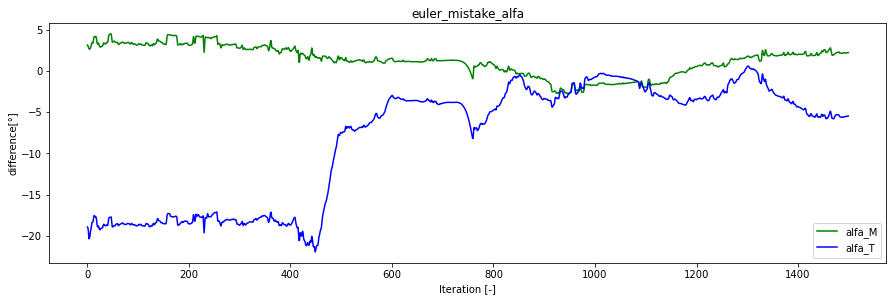

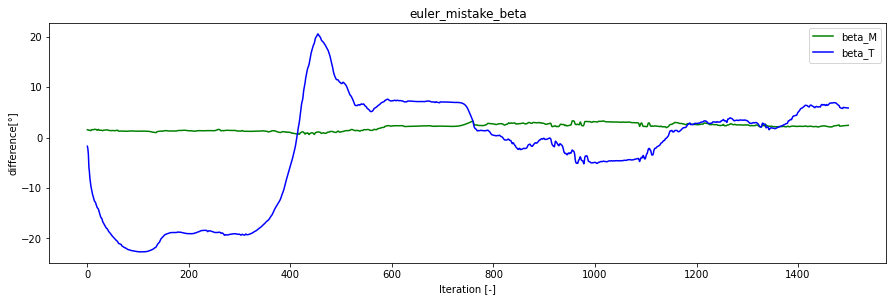

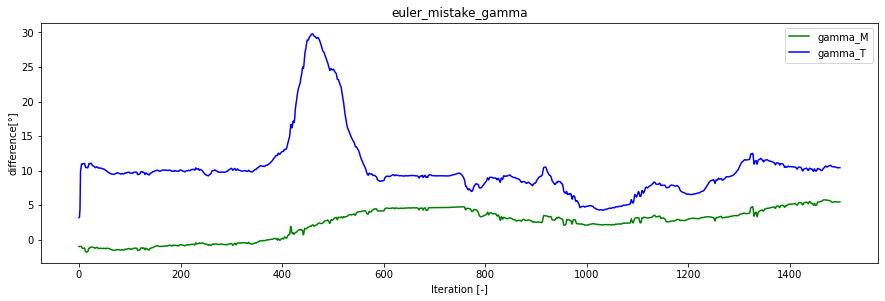

average differences Madgwick
alfa_M: 1.8929897057657847   beta_M: 2.0388005771106275   gamma_M: 2.798454527332326
average differences Transform
alfa_T: 8.263778859643816   beta_T: 8.456015430348351   gamma_T: 10.280718284773247


In [101]:
plt.figure(1, figsize=(15, 15))

plt.subplot(311)

plt.title("euler_mistake_alfa")
plt.plot(distance_alfa_M, color='green', label='alfa_M')
plt.plot(distance_alfa_T, color='blue', label='alfa_T')
plt.xlabel('Iteration [-]')
plt.ylabel( 'difference[°]')
plt.legend()
plt.show()

plt.figure(1, figsize=(15, 15))

plt.subplot(312)
plt.title("euler_mistake_beta")
plt.plot(distance_beta_M, color='green', label='beta_M')
plt.plot(distance_beta_T, color='blue', label='beta_T')
plt.xlabel('Iteration [-]')
plt.ylabel( 'difference[°]')
plt.legend()
plt.show()

plt.figure(1, figsize=(15, 15))

plt.subplot(313)
plt.title("euler_mistake_gamma")
plt.plot(distance_gamma_M, color='green', label='gamma_M')
plt.plot(distance_gamma_T, color='blue', label='gamma_T')
plt.xlabel('Iteration [-]')
plt.ylabel( 'difference[°]')
plt.legend()
plt.show()


avg_gamma_M = np.average(np.abs(distance_gamma_M))
avg_beta_M = np.average(np.abs(distance_beta_M))
avg_alfa_M = np.average(np.abs(distance_alfa_M))

avg_gamma_T = np.average(np.abs(distance_gamma_T))
avg_beta_T = np.average(np.abs(distance_beta_T))
avg_alfa_T = np.average(np.abs(distance_alfa_T))

print('average differences Madgwick')
print('alfa_M:',avg_alfa_M,'  beta_M:',avg_beta_M, '  gamma_M:', avg_gamma_M)


print('average differences Transform')
print('alfa_T:',avg_alfa_T,'  beta_T:',avg_beta_T, '  gamma_T:', avg_gamma_T)